In [1]:
#clear all variables
%reset -f

from class_and_functions_for_combinations import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dir_names = ['tmp', 'tmp/dss', 'tmp/evals', 'tmp/hes', 'tmp/models', 'tmp/real_dss/', 'tmp/training_combinations/']
for dir_name in dir_names:
    if not os.path.exists(dir_name):
        print('creating directory: ', dir_name)
        os.makedirs(dir_name)
# device = torch.device("cpu")

cuda


In [2]:
# #############
# architecture_vars = ['a']
# droput_vars = [0.3]

# steer_noise_level_vars = [0, 3, 6, 9, 12, 14, 16]
# he_distance_vars = [0.4, 0.6, 0.8]

# canny1_vars = [100]
# canny2_vars = [200]
# blur_vars = [3]
# img_noise_vars = [80]
# keep_bottom_vars = [2/3, 0.9]
# ds_length_vars = [5000, 1000]
# img_size_vars = [32]

# batch_size_vars = [65536]
# lr_vars = [0.3, 0.03, 0.003]
# epochs_vars = [100, 300, 900]
# L1_lambda_vars = [1e-3, 1e-4]
# L2_lambda_vars = [1e-1, 1e-2]
# weight_decay_vars = [9e-5, 9e-6]

In [3]:
#############
architecture_vars = ['a']
droput_vars = [0.3]

steer_noise_level_vars = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]#[0,4,8,10,12,16,20]#[0,2, 4,6, 8, 10, 12, 14, 16, 18, 20]
he_distance_vars = [.5]#[.3,.4,.5,.6,.7,.8,.9]#[.2,.3,.4,.5,.6,.7,.8,.9]#[.4,.6,.8]#[.3,.4,.5,.55,.6,.7,.8,.9]

canny1_vars = [100]#[100, 0]
canny2_vars = [200]#[200, 0]
blur_vars = [3]#[0,3,5,7,9]
img_noise_vars = [80]#[0,40,80,120,160]
keep_bottom_vars = [.7]#[.4,.5,.6,.7,.8,.9]#[.8]#[.4,.5,.6,.7,.8,.9]
ds_length_vars = [10000]
img_size_vars = [32]

batch_size_vars = [65536]
lr_vars = [3e-3]#[1e-1, 1e-2, 1e-3, 1e-4, 1e-5]#[0.003]
epochs_vars = [100]
L1_lambda_vars = [1e-4]
L2_lambda_vars = [1e-2]
weight_decay_vars = [9e-1,9e-2,9e-3,9e-4,9e-5,9e-6,9e-7]#[9e-5] #5e-2

In [4]:
#generate datasets names
#names and parameters
datasets = []
for steer_noise_level in steer_noise_level_vars:
    for he_distance in he_distance_vars:
        for canny1, canny2 in zip(canny1_vars, canny2_vars):
            for blur in blur_vars:
                for img_noise in img_noise_vars:
                    for keep_bottom in keep_bottom_vars:
                        for img_size in img_size_vars:
                            for ds_length in ds_length_vars:
                                name = f'ds_sn{steer_noise_level:.0f}_he{100*he_distance:.0f}_canny{canny1}_{canny2}_blur{blur:.0f}_noise{img_noise:.0f}_keep{100*keep_bottom:.0f}_size{img_size:.0f}_length{ds_length:.0f}'
                                params = {'name':name, 'steer_noise_level': steer_noise_level, 'he_distance': he_distance, 'canny1': canny1, 'canny2': canny2, 'blur': blur, 'img_noise': img_noise, 'keep_bottom': keep_bottom, 'img_size': img_size, 'ds_length': ds_length}
                                datasets.append(params)

print(f'total dataset combinations: {len(datasets)}')

all_names = []
for ds in datasets:
    all_names.append(ds['name'])
#check if there are duplicates
print(f'number of unique names: {len(set(all_names))}, number of names: {len(all_names)}')

total dataset combinations: 11
number of unique names: 11, number of names: 11


In [5]:
# PREPARE DATASETS
for ds in tqdm(datasets):
    prepare_ds(ds)

100%|██████████| 11/11 [00:00<00:00, 59532.06it/s]


In [6]:
# # ANALYZE DATASETS
# for ds in tqdm(datasets):
#     analyze_ds(ds)

In [7]:
#create starting network
epochs = 500

assert len(architecture_vars) == len(img_size_vars) == 1, 'only one architecture and one img_noise is allowed'
for a,size in zip(architecture_vars, img_size_vars):
    net_name = f'base_{a}_{size}'
    if os.path.exists(f'tmp/models/{net_name}.pt'):
        print('base network already exists')
        break

    all_imgs = []
    all_hes = []
    for ds_params in datasets:
        ds_name = ds_params['name']
        npz = my_load(f'tmp/dss/{ds_name}.npz', allow_pickle=True)
        imgs, hes = npz['imgs'], npz['hes']
        for img, he in zip(imgs, hes):
            all_imgs.append(img)
            all_hes.append(he)
    all_imgs = np.array(all_imgs)
    all_hes = np.array(all_hes)
    big_ds_name = f'big_ds_{a}_{size}'
    np.savez(f'tmp/dss/{big_ds_name}.npz', imgs=all_imgs, hes=all_hes, name=big_ds_name, img_size=size)
    print(f'base network: {all_imgs.shape}, {all_hes.shape}')
    ds = MyDataset(big_ds_name, device=device)
        #create model
    net = HEstimator()
    net.apply(reset_weights)
    net.to(device)

    #create dataloader
    train_size = int(0.8 * len(ds))
    val_size = len(ds) - train_size
    train_ds, val_ds = torch.utils.data.random_split(ds, [train_size, val_size])

    train_dataloader = DataLoader(train_ds, batch_size=2*65536, shuffle=True)
    val_dataloader = DataLoader(val_ds, batch_size=2*65536, shuffle=False)

    optimizer = torch.optim.Adam(net.parameters(), lr=0.003, weight_decay=9e-5)
    regr_loss_fn1 = nn.MSELoss() #before epochs/2
    regr_loss_fn2 = nn.MSELoss() #after epochs/2 for finetuning

    #train

    best_val = np.inf
    best_epoch = 0
    best_model = None
    losses = np.zeros((epochs, 2))
    for epoch in tqdm(range(epochs)):
        regr_loss_fn = regr_loss_fn1 if epoch < epochs//2 else regr_loss_fn2
        he_loss = train_epoch(net, train_dataloader, regr_loss_fn, optimizer, 1e-4, 1e-2)
        val_he_loss = val_epoch(net, val_dataloader, regr_loss_fn)
        losses[epoch, 0] = he_loss
        losses[epoch, 1] = val_he_loss
        clear_output(wait=False)
        if val_he_loss < best_val:
            best_val = val_he_loss
            best_epoch = epoch
            best_model = deepcopy(net)
            print('saved model')
            # torch.save(net.state_dict(), f'tmp/models/{net_name}.pt')
        print(f'he_loss {he_loss:.4f}, val_he_loss {val_he_loss:.4f}, best_val {best_val:.4f}, best_epoch {best_epoch}')

    #save losses
    # np.save(f'tmp/{name}_losses.npy', losses)
    torch.save(best_model.state_dict(), f'tmp/models/{net_name}.pt')


base network already exists


In [8]:
#create training combinations
trainings_combinations = []
for ds in datasets:
    for architecture in architecture_vars:
        for batch_size in batch_size_vars:
            for lr in lr_vars:
                for epochs in epochs_vars:
                    for L1_lambda in L1_lambda_vars:
                        for L2_lambda in L2_lambda_vars:
                            for weight_decay in weight_decay_vars:
                                for dropout in droput_vars:
                                    name = f'tr_{ds["name"]}_arch{architecture}_bs{batch_size:.0f}_lr{lr*10**6:.0f}_ep{epochs:.0f}_L1{L1_lambda*10**6:.0f}_L2{L2_lambda*10**6:.0f}_wd{weight_decay*10**6:.0f}_dr{dropout*100:.0f}'
                                    params = {'name':name, 'ds_name': ds['name'], 'architecture': architecture, 'batch_size': batch_size, 'lr': lr, 'epochs': epochs, 'L1_lambda': L1_lambda, 'L2_lambda': L2_lambda, 'weight_decay': weight_decay, 'dropout': dropout}
                                    trainings_combinations.append(params)

all_names = []
for tr in trainings_combinations:
    all_names.append(tr['name'])
#check if there are duplicates
print(f'number of unique names: {len(set(all_names))}, number of names: {len(all_names)}')

print(f'total training combinations: {len(trainings_combinations)}')

number of unique names: 77, number of names: 77
total training combinations: 77


In [9]:
#TRAINING 
for tr in tqdm(trainings_combinations):
    train(tr, device)

100%|██████████| 77/77 [29:18<00:00, 22.83s/it]


In [10]:
# EVALUATION
for tr in tqdm(trainings_combinations):
    evaluate(tr, eval_datasets=REAL_EVALUATION_DATASETS, device=device, show_imgs=False)


100%|██████████| 77/77 [05:44<00:00,  4.48s/it]


## Best MSEs

100%|██████████| 77/77 [00:00<00:00, 272.30it/s]


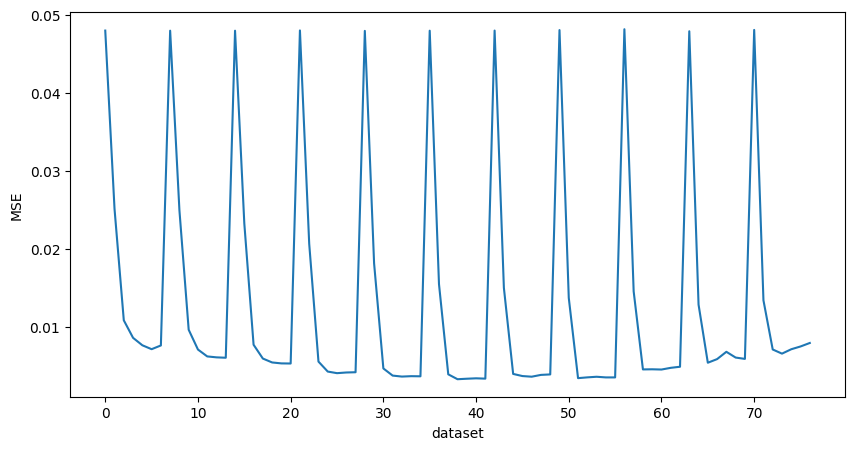

best combination: {'name': 'tr_ds_sn10_he50_canny100_200_blur3_noise80_keep70_size32_length10000_archa_bs65536_lr3000_ep100_L1100_L210000_wd900_dr30', 'ds_name': 'ds_sn10_he50_canny100_200_blur3_noise80_keep70_size32_length10000', 'architecture': 'a', 'batch_size': 65536, 'lr': 0.003, 'epochs': 100, 'L1_lambda': 0.0001, 'L2_lambda': 0.01, 'weight_decay': 0.0009, 'dropout': 0.3}, best MSE: 0.0033088968111261797


In [11]:
#BEST result REAL_EVALUATION_DATASETS
best_combination, best_MSE, all_MSE = get_best_result(trainings_combinations, eval_datasets=REAL_EVALUATION_DATASETS, device=device)

#plot mses
fig, ax = plt.subplots(figsize=(10, 5))
# ax.scatter(np.arange(len(all_MSE)), all_MSE)
ax.plot(np.arange(len(all_MSE)), all_MSE)
ax.set_xlabel('dataset')
ax.set_ylabel('MSE')
#y limits
# ax.set_ylim(0, 0.2)
plt.show()

print(f'best combination: {best_combination}, best MSE: {best_MSE}')


100%|██████████| 77/77 [00:00<00:00, 760.05it/s]


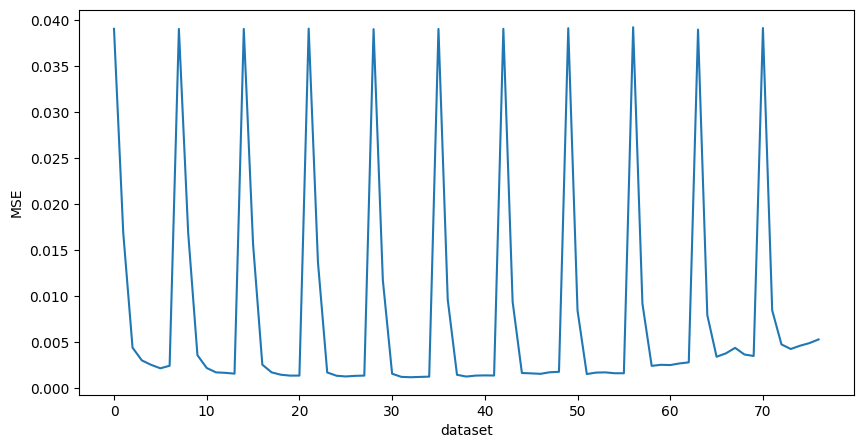

best combination: {'name': 'tr_ds_sn8_he50_canny100_200_blur3_noise80_keep70_size32_length10000_archa_bs65536_lr3000_ep100_L1100_L210000_wd90_dr30', 'ds_name': 'ds_sn8_he50_canny100_200_blur3_noise80_keep70_size32_length10000', 'architecture': 'a', 'batch_size': 65536, 'lr': 0.003, 'epochs': 100, 'L1_lambda': 0.0001, 'L2_lambda': 0.01, 'weight_decay': 9e-05, 'dropout': 0.3}, best MSE: 0.001204771510584867


In [12]:
#BEST result REAL_CLEAN_DATASETS
best_combination, best_MSE, all_MSE = get_best_result(trainings_combinations, eval_datasets=REAL_CLEAN_DATASETS, device=device)

#plot mses
fig, ax = plt.subplots(figsize=(10, 5))
# ax.scatter(np.arange(len(all_MSE)), all_MSE)
ax.plot(np.arange(len(all_MSE)), all_MSE)
ax.set_xlabel('dataset')
ax.set_ylabel('MSE')
#y limits
# ax.set_ylim(0, 0.2)
plt.show()

print(f'best combination: {best_combination}, best MSE: {best_MSE}')


100%|██████████| 77/77 [00:00<00:00, 961.98it/s]


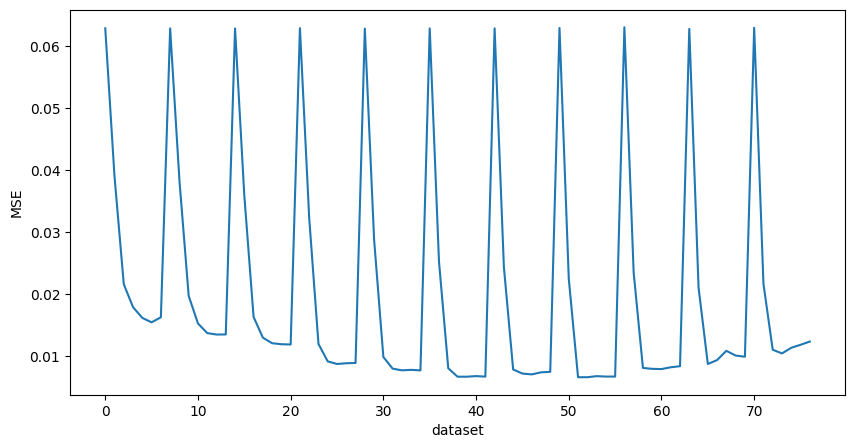

best combination: {'name': 'tr_ds_sn14_he50_canny100_200_blur3_noise80_keep70_size32_length10000_archa_bs65536_lr3000_ep100_L1100_L210000_wd900_dr30', 'ds_name': 'ds_sn14_he50_canny100_200_blur3_noise80_keep70_size32_length10000', 'architecture': 'a', 'batch_size': 65536, 'lr': 0.003, 'epochs': 100, 'L1_lambda': 0.0001, 'L2_lambda': 0.01, 'weight_decay': 0.0009, 'dropout': 0.3}, best MSE: 0.006609613543483124


In [13]:
#BEST result REAL_NOISY_DATASETS
best_combination, best_MSE, all_MSE = get_best_result(trainings_combinations, eval_datasets=REAL_NOISY_DATASETS, device=device)

#plot mses
fig, ax = plt.subplots(figsize=(10, 5))
# ax.scatter(np.arange(len(all_MSE)), all_MSE)
ax.plot(np.arange(len(all_MSE)), all_MSE)
ax.set_xlabel('dataset')
ax.set_ylabel('MSE')
#y limits
# ax.set_ylim(0, 0.2)
plt.show()

print(f'best combination: {best_combination}, best MSE: {best_MSE}')

best combination: {'name': 'tr_ds_sn5_he40_canny100_200_blur3_noise80_keep67_size32_length1000_archa_bs65536_lr30000_ep300_L1100_L210000_wd90_dr30', 'ds_name': 'ds_sn5_he40_canny100_200_blur3_noise80_keep67_size32_length1000', 'architecture': 'a', 'batch_size': 65536, 'lr': 0.03, 'epochs': 300, 'L1_lambda': 0.0001, 'L2_lambda': 0.01, 'weight_decay': 9e-05, 'dropout': 0.3}, best MSE: 0.036422715537554835

## Single plots

100%|██████████| 77/77 [00:01<00:00, 73.49it/s]


Found 11 different values for steer_noise_level, min_num_vals=7, max_num_vals=7


100%|██████████| 77/77 [00:01<00:00, 73.37it/s]


Found 11 different values for steer_noise_level, min_num_vals=7, max_num_vals=7


100%|██████████| 77/77 [00:01<00:00, 72.96it/s]


Found 11 different values for steer_noise_level, min_num_vals=7, max_num_vals=7


100%|██████████| 11/11 [00:00<00:00, 67.01it/s]


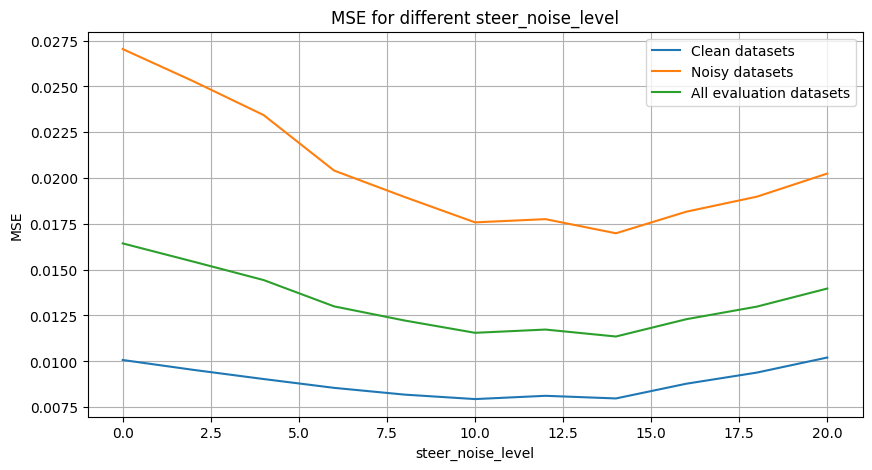

In [14]:
#plot for steer_noise_level 
steer_noise_level_MSEs = get_MSEs_for('steer_noise_level', trainings_combinations, LIST_REAL_DATASETS)

In [15]:
#plot for he_distance
he_distance_MSEs = get_MSEs_for('he_distance', trainings_combinations, LIST_REAL_DATASETS)

100%|██████████| 77/77 [00:01<00:00, 70.09it/s]

Found 1 different values for he_distance, min_num_vals=77, max_num_vals=77


In [16]:
#plot for lr
lr_MSEs = get_MSEs_for('lr', trainings_combinations, LIST_REAL_DATASETS, log=True)

100%|██████████| 77/77 [00:01<00:00, 70.53it/s]

Found 1 different values for lr, min_num_vals=77, max_num_vals=77


In [17]:
#plot for epochs
epochs_MSEs = get_MSEs_for('epochs', trainings_combinations, LIST_REAL_DATASETS)

100%|██████████| 77/77 [00:01<00:00, 71.29it/s]

Found 1 different values for epochs, min_num_vals=77, max_num_vals=77


In [18]:
#plot for img_noise_vars
img_noise_vars_MSEs = get_MSEs_for('img_noise', trainings_combinations, LIST_REAL_DATASETS)

100%|██████████| 77/77 [00:01<00:00, 70.35it/s]

Found 1 different values for img_noise, min_num_vals=77, max_num_vals=77


In [19]:
#plot for keep_bottom
keep_bottom_MSEs = get_MSEs_for('keep_bottom', trainings_combinations, LIST_REAL_DATASETS)

100%|██████████| 77/77 [00:01<00:00, 68.29it/s]

Found 1 different values for keep_bottom, min_num_vals=77, max_num_vals=77


In [20]:
#plto for img_noise
img_noise_MSEs = get_MSEs_for('img_noise', trainings_combinations, LIST_REAL_DATASETS)

100%|██████████| 77/77 [00:01<00:00, 68.14it/s]

Found 1 different values for img_noise, min_num_vals=77, max_num_vals=77


In [21]:
#plot for blur
blur_MSEs = get_MSEs_for('blur', trainings_combinations, LIST_REAL_DATASETS)

100%|██████████| 77/77 [00:01<00:00, 67.99it/s]

Found 1 different values for blur, min_num_vals=77, max_num_vals=77


100%|██████████| 77/77 [00:01<00:00, 71.55it/s]


Found 7 different values for weight_decay, min_num_vals=11, max_num_vals=11


100%|██████████| 77/77 [00:01<00:00, 72.07it/s]


Found 7 different values for weight_decay, min_num_vals=11, max_num_vals=11


100%|██████████| 77/77 [00:01<00:00, 74.02it/s]


Found 7 different values for weight_decay, min_num_vals=11, max_num_vals=11


100%|██████████| 7/7 [00:00<00:00, 43.86it/s]


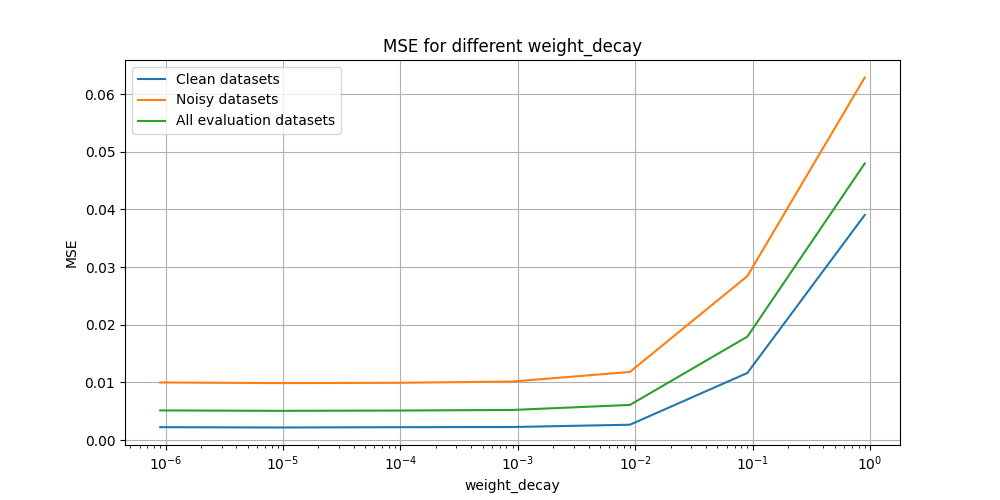

In [28]:
#plot for weight_decay
weight_decay_MSEs = get_MSEs_for('weight_decay', trainings_combinations, LIST_REAL_DATASETS, log=True)

## Double Plots

In [22]:
#plot for steer_noise_level and he_distance
%matplotlib widget
steer_noise_level_he_distance_MSEs = get2D_MSEs_for('steer_noise_level', 'he_distance', trainings_combinations, eval_datasets=REAL_EVALUATION_DATASETS)

100%|██████████| 77/77 [00:01<00:00, 70.22it/s]

Found 11 different values for steer_noise_level
Found 1 different values for he_distance
Found 11 different values for steer_noise_level and he_distance


In [23]:
#plot for steer_noise_level and img_noise_vars
%matplotlib widget
steer_noise_level_img_noise_vars_MSEs = get2D_MSEs_for('steer_noise_level', 'img_noise', trainings_combinations, eval_datasets=REAL_EVALUATION_DATASETS)

100%|██████████| 77/77 [00:01<00:00, 69.65it/s]

Found 11 different values for steer_noise_level
Found 1 different values for img_noise
Found 11 different values for steer_noise_level and img_noise


In [24]:
#plot for he_distance and keep_bottom
%matplotlib widget
he_distance_keep_bottom_MSEs = get2D_MSEs_for('he_distance', 'keep_bottom', trainings_combinations, eval_datasets=REAL_EVALUATION_DATASETS)

100%|██████████| 77/77 [00:01<00:00, 65.78it/s]

Found 1 different values for he_distance
Found 1 different values for keep_bottom
Found 1 different values for he_distance and keep_bottom


In [25]:
for name in all_names_used:
    print(name)

tmp/dss/ds_sn0_he50_canny100_200_blur3_noise80_keep70_size32_length10000.npz
tmp/training_combinations/tr_ds_sn0_he50_canny100_200_blur3_noise80_keep70_size32_length10000_archa_bs65536_lr3000_ep100_L1100_L210000_wd900000_dr30.npz
tmp/training_combinations/tr_ds_sn0_he50_canny100_200_blur3_noise80_keep70_size32_length10000_archa_bs65536_lr3000_ep100_L1100_L210000_wd90000_dr30.npz
tmp/training_combinations/tr_ds_sn0_he50_canny100_200_blur3_noise80_keep70_size32_length10000_archa_bs65536_lr3000_ep100_L1100_L210000_wd9000_dr30.npz
tmp/training_combinations/tr_ds_sn0_he50_canny100_200_blur3_noise80_keep70_size32_length10000_archa_bs65536_lr3000_ep100_L1100_L210000_wd900_dr30.npz
tmp/training_combinations/tr_ds_sn0_he50_canny100_200_blur3_noise80_keep70_size32_length10000_archa_bs65536_lr3000_ep100_L1100_L210000_wd9_dr30.npz
tmp/training_combinations/tr_ds_sn0_he50_canny100_200_blur3_noise80_keep70_size32_length10000_archa_bs65536_lr3000_ep100_L1100_L210000_wd1_dr30.npz
tmp/dss/ds_sn2_he50_c

In [26]:
raise SystemExit

SystemExit: 

/home/irong/dlenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# !!! CLEARING DATA !!!
import shutil
import os
folders = ['dss', 'evals', 'hes', 'models', 'real_dss', 'to_del', 'training_combinations']
folders = ['to_del']
for folder in folders:
    folder_path = f'tmp/{folder}'
    shutil.rmtree(folder_path)
    os.mkdir(folder_path)

In [ ]:
raise SystemExit

In [ ]:
# testN = HEstimator()
# a = np.array([1,2,3,4,5,6,7,8,9,10])
# print(testN)
# print(a)
# np.savez('testN', testN=testN, a=a)
import numpy as np
loadedN = np.load('testN.npz', allow_pickle=True)['testN']
loadeda = np.load('testN.npz', allow_pickle=True)['a']
print(loadedN)
print(loadeda)

In [ ]:
lane_keeper_ahead = HEstimator()
lane_keeper_ahead.to(device)

name_dataset = 'big_ds_a_80' #'saved_tests/train18' #'saved_tests/sim_dataset0'
#create dataset #takes a long time but then training is faster
train_dataset = MyDataset(name_dataset, device=device)

#split dataset into train and val
train_size = int(0.9*len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# DATALOADERS
train_dataloader = DataLoader(train_dataset, batch_size=8*8192, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8192, shuffle=False)

In [ ]:
# TRAINING 
#parameters
lr = 0.003 #0.005
epochs = 100 #500
#regularization is applied only to convolutional section, add weight decay to apply it to all layers
L1_lambda = 1e-4 #9e-4
L2_lambda = 1e-2 #1e-2
optimizer = torch.optim.Adam(lane_keeper_ahead.parameters(), lr=lr, weight_decay=9e-5) #wd = 2e-3# 3e-5
regr_loss_fn1 = nn.MSELoss() #before epochs/2
regr_loss_fn2 = nn.MSELoss() #after epochs/2 for finetuning

best_val = 100
best_epoch = 0

for epoch in range(epochs):
    # try:
    if True:
        regr_loss_fn = regr_loss_fn1 if epoch < epochs//2 else regr_loss_fn2
        he_loss = train_epoch(lane_keeper_ahead, train_dataloader, regr_loss_fn, optimizer, L1_lambda, L2_lambda)
        val_he_loss = val_epoch(lane_keeper_ahead, val_dataloader, regr_loss_fn)
        clear_output(wait=False)
    # except Exception as e:
    #     print(e)
    #     torch.cuda.empty_cache()
    #     continue
    if val_he_loss < best_val:
        best_val = val_he_loss
        best_epoch = epoch
        torch.save(lane_keeper_ahead.state_dict(), model_name)
        print("model saved")
    
    print(f"Epoch  {epoch+1}/{epochs},  loss = {regr_loss_fn} \nhe_loss: {he_loss:.4f},   Val: {val_he_loss:.4f}, best_val: {best_val:.4f}, best_epoch: {best_epoch}")
    # print(f"lat_err_loss2: {err_loss2:.4f},   Val: {val_loss2:.4f}")
    # print(f"curv_loss: {curv_loss}")

#Note: sweet spot for training is around 0.016 -> 0.020, also note that training can get stuck, and loss can start improving randomly

In [ ]:
# EVALUATE ON TEST SET (UNSEEN DATA)
lane_keeper_ahead.load_state_dict(torch.load(model_name))
he_loss = val_epoch(lane_keeper_ahead, val_dataloader, regr_loss_fn)

# print(f"lateral_err2_loss: {err_loss2}")
print(f"he loss: {he_loss}")

In [ ]:
# VISUALIZE CONVOLUTIONAL FILTERS
conv_layers = []
children = list(lane_keeper_ahead.children())
for i in range(len(children)):
    if isinstance(children[i], nn.Conv2d):
        conv_layers.append(children[i])
    elif isinstance(children[i], nn.Sequential):
        for child in children[i].children():
            if isinstance(child, nn.Conv2d):
                conv_layers.append(child)

c0 = conv_layers[0].weight.data.cpu().numpy()
c1 = conv_layers[1].weight.data.cpu().numpy()
c2 = conv_layers[2].weight.data.cpu().numpy()

def plot_nchw_data(data, h_num, v_num, title, size=(10, 10)):
    fig, axs = plt.subplots(h_num, v_num, figsize=size)
    shape = data.shape
    data = data.reshape(shape[0]*shape[1], shape[2], shape[3])
    for idx, ax in enumerate(axs.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        if idx < len(data):
            ax.imshow(data[idx,:,:], cmap='gray')
    plt.suptitle(title)
    #plt.tight_layout(rect=[0, 0, 1, 0.97], h_pad=0, w_pad=0)
    plt.show()
    return fig

# fig0 = plot_nchw_data(c0, 4, 4, 'conv0')
print(c0.shape)
print(c1.shape)
print(c2.shape)

fig0 = plot_nchw_data(c0, 1, 4, 'conv0', size=(8,2))

fig1 = plot_nchw_data(c1, 4, 4, 'conv1', size=(5,5)) 

fig2 = plot_nchw_data(c2, 8, 8, 'conv2', size=(10,10))



In [ ]:
# CONVERT TO ONNX MODEL FOR OPENCV
lane_keeper_ahead.load_state_dict(torch.load(model_name))

#save the model so that opencv can load it
import torch
import torch.onnx
import torchvision
import torchvision.models as models

device = torch.device('cpu')
lane_keeper_ahead.to(device)

# set the model to inference mode
lane_keeper_ahead.eval()

# Create some sample input in the shape this model expects 
# This is needed because the convertion forward pass the network once 
dummy_input = torch.randn(1, 1, 32, 32)
torch.onnx.export(lane_keeper_ahead, dummy_input, onnx_lane_keeper_path, verbose=True)

clear_output(wait=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lane_keeper_ahead.to(device)